# Advanced Lane Lines Project Report

## Calibrating Image Distortions

Image distortions occur when transforming a 3D object to a 2D image due to type of lenses used by cameras. And this is an important issue when we would like to detect lane curvatures on video footages correctly.

The object being pictured has 3D coordinates P(X,Y,Z), however a pinhole camera transforms this information to form a 2D image p(x,y), just using a tranformative matrix called Camera matrix (C)
$$
P\approx Cp.
$$

when it is a camera with special lenses that taking pictures of 3D objects, the distortion usually can be captured by 5 numbers called distortion coefficients
$$
Distortion_{coeff} = (k_1, k_2, p_1, p_2, k_3).
$$

### How to detect distortions

It can be easily detected by taking pictures of the known shapes, such as a chessboard. Then knowing the distortion errors, the camera can be calibrated.

By taking multiple images of a chessboard on a flat surcase, we can detect the distortions by looking at the differences of size and shape of the squares. Then a transform can be created to map distorted points to undistorted points.

<img src='examples/undistort_output.png' alt='camera calibration' style='width:500px'>

### Calibrating Using OpenCV

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

(720, 1280, 3)
(720, 1280)


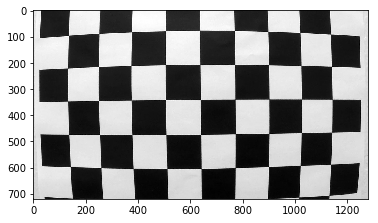

In [2]:
path = 'camera_cal/calibration1.jpg'
img = cv2.imread(path)

#cv2.imshow('chessboard', img)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print(img.shape)
print(gray.shape)
plt.imshow(gray, cmap='gray')
plt.show()

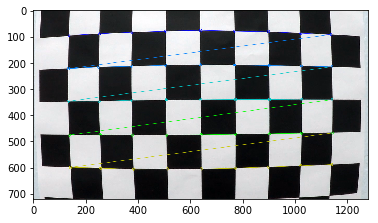

In [3]:
# Define the number of inner corners by rows and columns
nx = 9
ny = 5

# Find the corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.show()

We should use at least 20 images to calibrate accurately.

In [4]:
import glob

In [37]:
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

ny = 9
nx = 6

# prepare object points like (0, 0, 0), (1, 0, 0), (2, 0, 0), ..., (7, 5, 0)
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

images = glob.glob('./camera_cal/calibration*.jpg')

for path in images:
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # if corners are found, add object and image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp) # all object points will be the same for each imgpoints
        # draw and display corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)
        #plt.show()
        #plt.close()
        print('corners found for image: ' + path)

# now do the calibration, here c_mtx is the camera matrix
# and dist are the distiortion coefficients
# and rvecs is the rotation and the tvecs is the
# translation vectors.
ret, c_mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                      gray.shape[::-1], None, None)

corners found for image: ./camera_cal/calibration12.jpg
corners found for image: ./camera_cal/calibration3.jpg
corners found for image: ./camera_cal/calibration9.jpg
corners found for image: ./camera_cal/calibration13.jpg
corners found for image: ./camera_cal/calibration20.jpg
corners found for image: ./camera_cal/calibration19.jpg
corners found for image: ./camera_cal/calibration14.jpg
corners found for image: ./camera_cal/calibration16.jpg
corners found for image: ./camera_cal/calibration11.jpg
corners found for image: ./camera_cal/calibration10.jpg
corners found for image: ./camera_cal/calibration6.jpg
corners found for image: ./camera_cal/calibration15.jpg
corners found for image: ./camera_cal/calibration7.jpg
corners found for image: ./camera_cal/calibration2.jpg
corners found for image: ./camera_cal/calibration8.jpg
corners found for image: ./camera_cal/calibration18.jpg
corners found for image: ./camera_cal/calibration17.jpg


Now we have the distortion coefficients (dist) and the camera matrix (c_mtx), thus we now can create destination images (dst) by undistorting the original camera images.

Let's undistort the first chessboard image and see the result below.

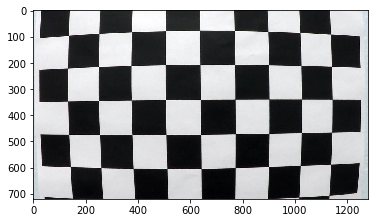

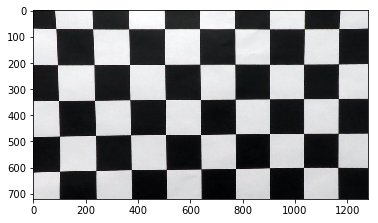

In [6]:
# we will calibrate one of the images:
img = cv2.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)
plt.show()
plt.close()

# and calibrate the image
dst = cv2.undistort(img, c_mtx, dist, None, c_mtx)

plt.imshow(dst)
plt.show()
plt.close()

The last image is the result of an undistorting image after applying camera calibration.

## Perspective Transform

An image gets smaller and smaller as it goes further away from the camera, and this phenomenon is known as perspective. And parallel lines appear to converge to a point.

As in the situation of an image of the road and the lane lines, the lane gets smaller as it gets further away from the camera. 

Mathematicly we can express this phenomenon as, in real world coordinates (X,Y,Z), greater the magnitude of an object's Z-coordinate, the smaller it will appear in an image.

A perspective transform uses this expression to transform an image by warping the image and dragging the points towards or pushing away from the camera.

Perpective transform (i.e. a bird's-eye view transform) is usefull, specifically, when the intention is to find the curvature of a lane.

To summarize, a perpective transform changes the perspective to view the same scene from different viewpoints and angles.

### Perspective Transform Using OpenCV

Selecting four points on an image is enough to define a linear transformation from one perspective to another. For this purpose let's choose an image from chessboard examples and apply view transform.

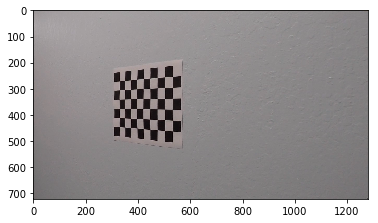

In [42]:
# first laod an image from chessboard images
img = cv2.imread('./camera_cal/calibration7.jpg')

plt.imshow(img)
plt.show()
plt.close()

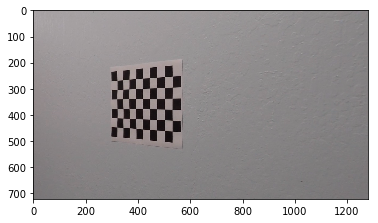

In [43]:
# now undistort the image
nx = 9
ny = 6

# we know c_mtx and dist from the previous section.
undist = cv2.undistort(img, c_mtx, dist, None, c_mtx)

plt.imshow(undist)
plt.show()
plt.close()

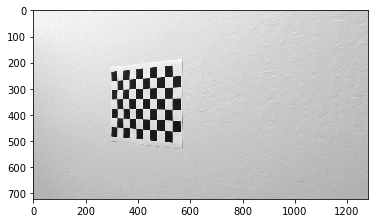

In [44]:
# convert image to single channel
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')
plt.show()
plt.close()

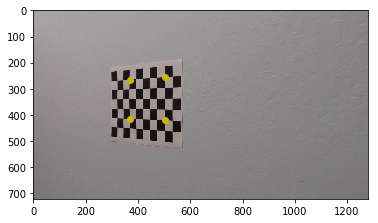

In [59]:
# let's automaticly find the points of corners and use them as referance
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# if found, use 4 of the points as marking a rectangle
if ret == True:
    pt1 = corners[2, 0]
    pt2 = corners[7, 0]
    pt3 = corners[43, 0]
    pt4 = corners[38, 0]
    # source points
    src = np.float32([pt1, pt2, pt3, pt4])
    # display marked points
    plt.imshow(undist)
    plt.plot(pt1[0], pt1[1], marker='o', color='y')
    plt.plot(pt2[0], pt2[1], marker='o', color='y')
    plt.plot(pt3[0], pt3[1], marker='o', color='y')
    plt.plot(pt4[0], pt4[1], marker='o', color='y')

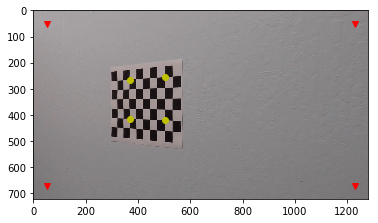

In [64]:
# now let's define destination points and change the perspective

img_size = gray.shape[::-1]

if ret == True:
    offset = 50
    pt21 = [offset, offset]
    pt22 = [img_size[0] - offset, offset]
    pt23 = [img_size[0] - offset, img_size[1] - offset]
    pt24 = [offset, img_size[1] - offset]
    dst = np.float32([pt21, pt22, pt23, pt24])
    # let's plot again
    plt.imshow(undist)
    plt.plot(pt1[0], pt1[1], marker='o', color='y')
    plt.plot(pt2[0], pt2[1], marker='o', color='y')
    plt.plot(pt3[0], pt3[1], marker='o', color='y')
    plt.plot(pt4[0], pt4[1], marker='o', color='y')
    plt.plot(pt21[0], pt21[1], marker='v', color='r')
    plt.plot(pt22[0], pt22[1], marker='v', color='r')
    plt.plot(pt23[0], pt23[1], marker='v', color='r')
    plt.plot(pt24[0], pt24[1], marker='v', color='r')
    plt.show()
    plt.close()

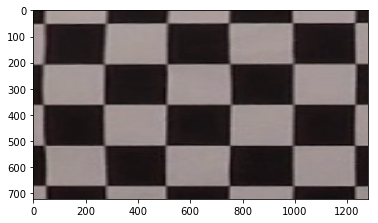

In [65]:
# now let's transform and see the result

if ret == True:
    # get transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # get tranformed image as named warped
    warped = cv2.warpPerspective(undist, M, img_size)
    plt.imshow(warped)
    plt.show()
    plt.close()